# Neuron circuits for Dorsophila
Tielin Zhang, 2019-6-13

Contains three groups of neurons:

(1)For information input group;

(2)For the inhibitory tuning group;

(3)for informatin output group;

In [1]:
from brian2 import *
import random

%matplotlib inline
apl_enable = False

In [2]:
20*volt
1000*amp
1e6*volt
1000*namp
10*mA*5*Mohm

50. * kvolt

In [3]:
start_scope()

### the possion input generator

In [4]:
inputnum = 10
Poisson = PoissonGroup(inputnum, 500*Hz)

## PN Group (input, LIF model)

A PN is modeled as the standard leaky integrate and fire (LIF) neuron. The membrane potential of a PN at time t is determined by the following differential equation, $\frac{dV}{dt} = \frac{(V0−V)}{\tau}+ I$, where $\tau$ is the membrane time constant and V0 is the resting potential. When the membrane potential of a PN exceeds the threshold value Vth, the PN emits a spike and the value of the membrane potential is reset to Vreset. After the spike emission, the PN enters an absolute refractory period that lasts for Vres. The membrane potential of a PN stays at Vres during the refractory period. The parameters in the leaky integrate-and-fire neuron model are set as follows: tau=5 ms,V0=−60mV,Vth=−45mV, Vreset=−80mV,and Vres =1 ms.

Around 150-200 PN neurons, or 100 neurons ? which one?

In [5]:
tau_pn = 5*ms
V0_pn = -60*mV
Vth_pn = -45*mV
Vres_pn = -80*mV
I_pn = 0*mV/ms
eqs_pn = '''
dv/dt = (V0_pn-v)/tau_pn + I_pn: volt
'''
G_pn = NeuronGroup(2, eqs_pn, threshold='v>Vth_pn', reset='v=Vres_pn', refractory=1*ms, method='linear') #method='Euler' linear
G_pn.v = -60*mV # initial value

In [6]:
debug = False
if debug:
    M_pn_stat = StateMonitor(G_pn, 'v', record=0)
    M_pn_spk = SpikeMonitor(G_pn)
    run(50*ms)
    figure(figsize=(12,4))
    subplot(121)
    plot(M_pn_stat.t/ms, M_pn_stat.v[0])
    xlabel('Time (ms)')
    ylabel('v');
    title('M_PN_V')
    subplot(122)
    plot(M_pn_spk.t/ms, M_pn_spk.i, '.k')
    xlabel('Time (ms)')
    ylabel('Neuron index');
    title('M_PN_SPK')

## KC Group (output, LIF model)

Here we use the similar LIF model for simplification.

Around 2500 KC neurons.


In [7]:
tau_kc = 5*ms
V0_kc = -60*mV
Vth_kc = -45*mV
Vres_kc = -80*mV
eqs_kc = '''
dv/dt = (V0_kc-v)/tau_kc : volt
'''
G_kc = NeuronGroup(10, eqs_kc, threshold='v>Vth_kc', reset='v=Vres_kc', refractory=1*ms, method='Euler') #method='Euler' linear
G_kc.v = -60*mV # initial value

In [8]:
debug = False
if debug:
    M_kc_stat = StateMonitor(G_kc, 'v', record=0)
    M_kc_spk = SpikeMonitor(G_kc)
    run(50*ms)
    figure(figsize=(12,4))
    subplot(121)
    plot(M_kc_stat.t/ms, M_kc_stat.v[0])
    xlabel('Time (ms)')
    ylabel('v');
    title('M_KC_V')
    subplot(122)
    plot(M_kc_spk.t/ms, M_kc_spk.i, '.k')
    xlabel('Time (ms)')
    ylabel('Neuron index');
    title('M_KC_SPK')

### APL Group (tuning inhibition, LIF model)

In [9]:
tau_apl = 5*ms
V0_apl = -60*mV  # attractors
Vth_apl = -45*mV
Vres_apl = -80*mV 
eqs_apl = '''
dv/dt = (V0_apl-v)/tau_apl : volt
'''
G_apl = NeuronGroup(1, eqs_apl, threshold='v>Vth_apl', reset='v=Vres_apl', refractory=1*ms, method='Euler') #method='Euler' linear
G_apl.v = -60*mV # initial value

### Connection between input Possion to PN

In [10]:
S_p_pn = Synapses(Poisson, G_pn, 'w : volt', on_pre='v_post += w')
S_p_pn.connect() # connect all-to-all
S_p_pn.w = '5*mV'

WARNING    C:\ProgramData\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Zhang\.cython\brian_extensions\_cython_magic_36ef093112cd1b088f6c8d6bb9179d1a.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]
WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


### Connection between PN to KC

(1) PN->KC, each KC neuron accept mean 6 PN Axonal Terminal, 

(2) Big PN Axonal terminal to 20 KC neuron, 

(3) Small PN Axonal terminal to 8 KC neuron,

You cannot fit both of these three conditions.!!

In [11]:
S_pn_kc = Synapses(G_pn, G_kc, 'w : volt', on_pre='v_post += w')

propertion = 0.5 # the big Pn proportion in source group
bigPn = np.arange( 0, int(propertion*G_pn.N), 1) 
smallPn = np.arange( int(propertion*G_pn.N), G_pn.N, 1) 

arrayi = []
arrayj = []

for i in range(G_pn.N):
    if i in bigPn:
        ifrom = [i]*8
        random.seed(1)
        ito = [random.randint(0,G_kc.N-1) for _ in range(8)]
    else:
        ifrom = [i]*4
        random.seed(1)
        ito = [random.randint(0,G_kc.N-1) for _ in range(4)]
    arrayi.extend(ifrom)
    arrayj.extend(ito)
# arrayi = [int(i) for i in arrayi]
# arrayj = [int(j) for j in arrayj]
S_pn_kc.connect(i=arrayi, j=arrayj)
S_pn_kc.w = '5*mV'

### Calculation: How many mean input numbers of the each KC gets.

In [12]:
print('The mean inputs of KC neuron is : '+ str(len(S_pn_kc.i)/G_kc.N))

The mean inputs of KC neuron is : 1.2


In [13]:
debug = False
if debug:
    M_pn = StateMonitor(G_pn, 'v', record=0)
    M_kc = StateMonitor(G_kc, 'v', record=0)

    run(50*ms)

    figure()
    subplot(121)
    plot(M_pn.t/ms, M_pn.v[0])
    xlabel('Time (ms)')
    ylabel('v');
    subplot(122)
    plot(M_kc.t/ms, M_kc.v[0])
    xlabel('Time (ms)')
    ylabel('v');

### Connection KC >> APL

In [14]:
S_kc_apl = Synapses(G_kc, G_apl, 'w : volt', on_pre='v_post += w')
S_kc_apl.connect() # connect all-to-all
if apl_enable:
    S_kc_apl.w = '5*mV'
else:
    S_kc_apl.w = '0*mV'

### Connection APL >> KC

In [15]:
S_apl_kc = Synapses(G_apl, G_kc, 'w : volt', on_pre='v_post += w')
S_apl_kc.connect() # connect all-to-all
if apl_enable:
    S_apl_kc.w = '-1*mV'
else:
    S_apl_kc.w = '0*mV'
        

### Connection APL >> PN

In [16]:
S_apl_pn = Synapses(G_apl, G_pn, 'w : volt', on_pre='v_post += w')
S_apl_pn.connect() # connect all-to-all
for j in range(G_pn.N):
    if apl_enable:
        if j in bigPn:
            S_apl_pn.w[0,j] = '-20*mV'
        else:
            S_apl_pn.w[0,j] = '-10*mV'
    else:
        S_apl_pn.w[0,j] = '0*mV'

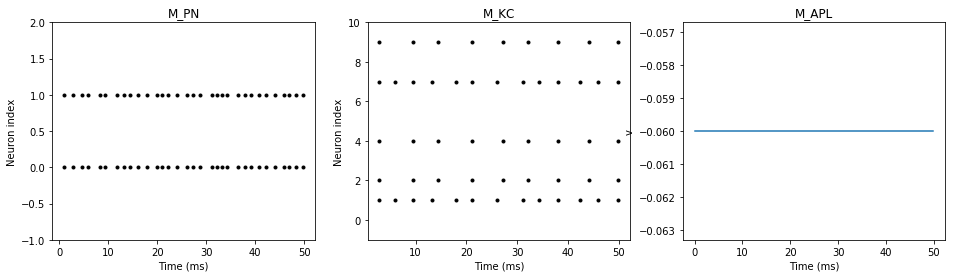

In [17]:
debug = True
if debug:
    M_pn = SpikeMonitor(G_pn)
    M_kc = SpikeMonitor(G_kc)
    M_apl = StateMonitor(G_apl, 'v', record=0)
    duration = 50*ms
    run(duration)

    figure(figsize=(16,4))
    subplot(131)
    plot(M_pn.t/ms, M_pn.i, '.k')
    xlabel('Time (ms)')
    ylabel('Neuron index');
    ylim(-1, G_pn.N)
    title('M_PN')
    subplot(132)
    plot(M_kc.t/ms, M_kc.i, '.k')
    xlabel('Time (ms)')
    ylabel('Neuron index');
    ylim(-1, G_kc.N)
    title('M_KC')
    subplot(133)
    plot(M_apl.t/ms, M_apl.v[0])
    xlabel('Time (ms)')
    ylabel('v');
    title('M_APL')

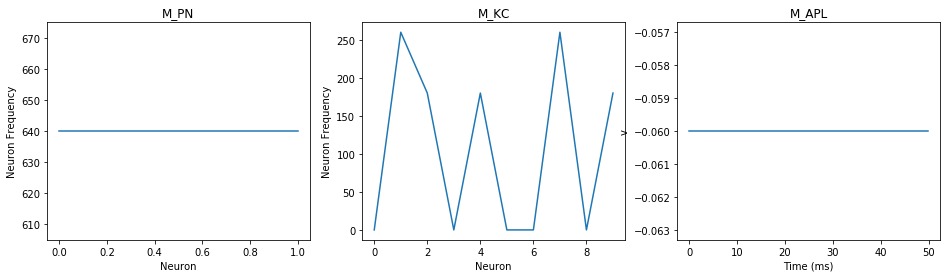

In [18]:
debug = True
if debug:
    figure(figsize=(16,4))
    subplot(131)
    plot(M_pn.count/duration)
    xlabel('Neuron')
    ylabel('Neuron Frequency');
    # ylim(-1, G_pn.N)
    title('M_PN')
    subplot(132)
    plot(M_kc.count/duration)
    xlabel('Neuron')
    ylabel('Neuron Frequency');
    # ylim(-1, G_kc.N)
    title('M_KC')
    subplot(133)
    plot(M_apl.t/ms, M_apl.v[0])
    xlabel('Time (ms)')
    ylabel('v');
    title('M_APL')